# Spotify x Billboard Five Year Analysis Project: Exploratory Analysis

## Import packages 

In [2]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
import seaborn as sns
from wordcloud import WordCloud
import fontTools
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

### Set Display Options

#### Set to display all columns (max 500)

In [3]:
pd.set_option('display.max_columns', 500)

#### Disable display window scrolling for notebook

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

## Import dataframes

### Import All Chart Tracks Table

In [5]:
df1=pd.read_csv("../data/AllChartAlbumTracksRecoded.csv")
df1.head()

,Unnamed: 0,track_name,track_id,track_popularity,track_artists,track_artists_ids,track_artists_genres,track_artists_popularity,track_explicit,track_artists_followers,album_name,album_id,danceability,energy,key,speechiness,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_artist,track_artist_id,track_artist_popularity,track_artist_followers,track_artists_genres_consolidate,main_genre,Soundtrack,Rock,Pop,Hip-hop,Edm,Latin,Indie,Christian,Country,Soul,Metal,Jazz,Folk,Funk,Misc,Easy_listening,R&B,Reggae,Show_tunes,No Genre Assigned
0,0,Sand In My Boots,4qeMbs55QlONyrE9YBMA93,42,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],['contemporary country'],[86],False,[2789002],Dangerous: The Double Album,1qW1C4kDOXnrly22daHbxz,0.354,0.540,3,0.0323,-6.625,1,0.587,0.00000,0.112,0.416,69.970,202133,4,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,86,2789002,['Country'],Country,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,Wasted On You,4xv9BDq764NSKG3geku9X2,42,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],['contemporary country'],[86],False,[2789002],Dangerous: The Double Album,1qW1C4kDOXnrly22daHbxz,0.505,0.658,11,0.0318,-5.240,0,0.371,0.00136,0.121,0.255,196.002,178520,3,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,86,2789002,['Country'],Country,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2,Somebody’s Problem,7cWMnSxmQfKFsIIoRWifbb,35,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],['contemporary country'],[86],False,[2789002],Dangerous: The Double Album,1qW1C4kDOXnrly22daHbxz,0.658,0.539,5,0.0289,-7.674,1,0.665,0.00000,0.123,0.622,136.959,161773,4,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,86,2789002,['Country'],Country,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,3,More Surprised Than Me,6Mn2GFiNNadK0G2ZXRK1fd,35,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],['contemporary country'],[86],False,[2789002],Dangerous: The Double Album,1qW1C4kDOXnrly22daHbxz,0.488,0.748,6,0.0297,-6.049,1,0.244,0.00000,0.124,0.431,84.938,157440,4,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,86,2789002,['Country'],Country,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,4,865,3lb2f27695Iuyd82khwU9k,38,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],['contemporary country'],[86],False,[2789002],Dangerous: The Double Album,1qW1C4kDOXnrly22daHbxz,0.454,0.586,8,0.0253,-5.254,1,0.729,0.00000,0.101,0.366,87.891,190680,4,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,86,2789002,['Country'],Country,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### Import Master Chart Table

In [6]:
df2=pd.read_csv("../data/MasterChartTableRecoded.csv")
df2.head()

,Unnamed: 0,playlist_id,playlist_name,position,album_name,album_id,album_release_date,album_artists,album_artists_ids,album_artists_genres,album_artists_popularity,album_artists_followers,track_name,track_id,track_popularity,track_artists,track_artists_ids,track_artists_genres,track_artists_popularity,track_explicit,track_artists_followers,danceability,energy,key,speechiness,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,album_artist,release_date_datetime,release_year
0,0,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,1,Dangerous: The Double Album,1qW1C4kDOXnrly22daHbxz,2021-01-08,Morgan Wallen,['4oUHIQIBe0LHzYfvXNW4QM'],[['contemporary country']],[86],[2789002],More Than My Hometown,65mMCEOu5Ll1DBAfEUmerU,34,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],[['contemporary country']],[86],False,[2789002],0.621,0.868,6,0.0460,-5.478,1,0.617000,0.000000,0.131,0.594,126.010,216573,4,Morgan Wallen,2021-01-08,2021
1,1,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,2,SOUR,6s84u2TUpR3wdUv4NgKA2j,2021-05-21,['Olivia Rodrigo'],['1McMsnEElThX1knmY4oliG'],[['pop']],[91],[12849364],drivers license,5wANPM4fQCJwkGd4rN57mH,92,['Olivia Rodrigo'],['1McMsnEElThX1knmY4oliG'],[['pop']],[91],True,[12849364],0.561,0.431,10,0.0578,-8.810,1,0.768000,0.000014,0.106,0.137,143.875,242013,4,Olivia Rodrigo,2021-05-21,2021
2,2,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,3,Shoot For The Stars Aim For The Moon,7e7t0MCrNDcJZsPwUKjmOc,2020-07-03,['Pop Smoke'],['0eDvMgVFoNV3TpwtrVCoTj'],[['brooklyn drill']],[89],[8935893],What You Know Bout Love,1tkg4EHVoqnhR6iFEXb60y,85,['Pop Smoke'],['0eDvMgVFoNV3TpwtrVCoTj'],[['brooklyn drill']],[89],True,[8935893],0.709,0.548,10,0.3530,-8.493,1,0.650000,0.000002,0.133,0.543,83.995,160000,4,Pop Smoke,2020-07-03,2020
3,3,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,4,evermore,2Xoteh7uEpea4TohMxjtaq,2020-12-11,['Taylor Swift'],['06HL4z0CvFAxyc27GXpf02'],[['pop']],[98],[48097228],willow,0lx2cLdOt3piJbcaXIV74f,82,['Taylor Swift'],['06HL4z0CvFAxyc27GXpf02'],[['pop']],[98],False,[48097228],0.392,0.574,7,0.1700,-9.195,1,0.833000,0.001790,0.145,0.529,81.112,214707,4,Taylor Swift,2020-12-11,2020
4,4,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,5,Certified Lover Boy,3SpBlxme9WbeQdI9kx7KAV,2021-09-03,['Drake'],['3TVXtAsR1Inumwj472S9r4'],"[['canadian hip hop', 'canadian pop', 'hip hop...",[98],[60310746],Way 2 Sexy (with Future & Young Thug),0k1WUmIRnG3xU6fvvDVfRG,88,"['Drake', 'Future', 'Young Thug']",['3TVXtAsR1Inumwj472S9r4'],"[['canadian hip hop', 'canadian pop', 'hip hop...",[98],True,[60310746],0.803,0.597,11,0.1410,-6.035,0,0.000619,0.000005,0.323,0.331,136.008,257605,4,Drake,2021-09-03,2021


In [7]:
position_int = list(df2['position'])
df2['chart_position'] = position_int

In [8]:
df3 = df2[["playlist_id", "playlist_name", "chart_position", "album_release_date", "release_year", "release_date_datetime", "album_id", 'album_artist']]

### Join Master Chart and All Track Tables on the Album ID

In [9]:
df4 = pd.merge(df3, df1, on='album_id')
df4.head()

,playlist_id,playlist_name,chart_position,album_release_date,release_year,release_date_datetime,album_id,album_artist,Unnamed: 0,track_name,track_id,track_popularity,track_artists,track_artists_ids,track_artists_genres,track_artists_popularity,track_explicit,track_artists_followers,album_name,danceability,energy,key,speechiness,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_artist,track_artist_id,track_artist_popularity,track_artist_followers,track_artists_genres_consolidate,main_genre,Soundtrack,Rock,Pop,Hip-hop,Edm,Latin,Indie,Christian,Country,Soul,Metal,Jazz,Folk,Funk,Misc,Easy_listening,R&B,Reggae,Show_tunes,No Genre Assigned
0,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,1,2021-01-08,2021,2021-01-08,1qW1C4kDOXnrly22daHbxz,Morgan Wallen,0,Sand In My Boots,4qeMbs55QlONyrE9YBMA93,42,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],['contemporary country'],[86],False,[2789002],Dangerous: The Double Album,0.354,0.540,3,0.0323,-6.625,1,0.587,0.00000,0.112,0.416,69.970,202133,4,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,86,2789002,['Country'],Country,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,1,2021-01-08,2021,2021-01-08,1qW1C4kDOXnrly22daHbxz,Morgan Wallen,1,Wasted On You,4xv9BDq764NSKG3geku9X2,42,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],['contemporary country'],[86],False,[2789002],Dangerous: The Double Album,0.505,0.658,11,0.0318,-5.240,0,0.371,0.00136,0.121,0.255,196.002,178520,3,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,86,2789002,['Country'],Country,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,1,2021-01-08,2021,2021-01-08,1qW1C4kDOXnrly22daHbxz,Morgan Wallen,2,Somebody’s Problem,7cWMnSxmQfKFsIIoRWifbb,35,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],['contemporary country'],[86],False,[2789002],Dangerous: The Double Album,0.658,0.539,5,0.0289,-7.674,1,0.665,0.00000,0.123,0.622,136.959,161773,4,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,86,2789002,['Country'],Country,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,1,2021-01-08,2021,2021-01-08,1qW1C4kDOXnrly22daHbxz,Morgan Wallen,3,More Surprised Than Me,6Mn2GFiNNadK0G2ZXRK1fd,35,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],['contemporary country'],[86],False,[2789002],Dangerous: The Double Album,0.488,0.748,6,0.0297,-6.049,1,0.244,0.00000,0.124,0.431,84.938,157440,4,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,86,2789002,['Country'],Country,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,1,2021-01-08,2021,2021-01-08,1qW1C4kDOXnrly22daHbxz,Morgan Wallen,4,865,3lb2f27695Iuyd82khwU9k,38,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],['contemporary country'],[86],False,[2789002],Dangerous: The Double Album,0.454,0.586,8,0.0253,-5.254,1,0.729,0.00000,0.101,0.366,87.891,190680,4,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,86,2789002,['Country'],Country,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [10]:
df4 = df4.drop("Unnamed: 0", axis=1)

In [11]:
df4.to_csv('../data/AllTracksAndChartsJoined.csv')

#### Select five most popular songs for each album on chart

In [12]:
df5 = df4.sort_values('track_popularity', ascending = False).groupby(['playlist_name', 'album_id']).head(5)

In [13]:
df5.to_csv('../data/MostPopularAlbumTracksAllChartsJoined.csv')

## Explorations

### Preliminary Questions

#### Shape of the dataframe:

In [14]:
df4.shape
#(rows, columns)

(16501, 57)

#### Most popular song in dataset:

In [15]:
np.max(df4['track_popularity'])

95

In [16]:
df4.loc[df4['track_popularity'] == 95]

,playlist_id,playlist_name,chart_position,album_release_date,release_year,release_date_datetime,album_id,album_artist,track_name,track_id,track_popularity,track_artists,track_artists_ids,track_artists_genres,track_artists_popularity,track_explicit,track_artists_followers,album_name,danceability,energy,key,speechiness,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_artist,track_artist_id,track_artist_popularity,track_artist_followers,track_artists_genres_consolidate,main_genre,Soundtrack,Rock,Pop,Hip-hop,Edm,Latin,Indie,Christian,Country,Soul,Metal,Jazz,Folk,Funk,Misc,Easy_listening,R&B,Reggae,Show_tunes,No Genre Assigned
35,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,2,2021-05-21,2021,2021-05-21,6s84u2TUpR3wdUv4NgKA2j,Olivia Rodrigo,good 4 u,4ZtFanR9U6ndgddUvNcjcG,95,['Olivia Rodrigo'],['1McMsnEElThX1knmY4oliG'],['pop'],[91],True,[12849364],SOUR,0.563,0.664,9,0.1540,-5.044,1,0.3350,0.00000,0.0849,0.688,166.928,178147,4,Olivia Rodrigo,1McMsnEElThX1knmY4oliG,91,12849364,['Pop'],Pop,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
501,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,20,2021-06-25,2021,2021-06-25,1nAQbHeOWTfQzbOoFrvndW,Doja Cat,Woman,6Uj1ctrBOjOas8xZXGqKk4,95,['Doja Cat'],['5cj0lLjcoR7YOSnhnX0Po5'],"['dance pop', 'pop']",[94],True,[14664252],Planet Her,0.824,0.764,5,0.0854,-4.175,0,0.0888,0.00294,0.1170,0.881,107.998,172627,4,Doja Cat,5cj0lLjcoR7YOSnhnX0Po5,94,14664252,"['Pop', 'Pop']",Pop,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
# A fun note: when we originally ran this dataset on December 27, 2021, the most popular track
# was Mariah Carey's "All I Want For Christmas Is You," which was to be expected since we'd just 
# gone through the holidays and of course that track was being played constantly. On a subsequent 
# update a few weeks later, the popularity values had changed, because Spotify's popularity score
# is based on current play frequency and a track being played more now than in the past will likely
# have a higher score. Fun to see the popularity value claculation change in action! Search for that 
# tracks now returns no rows for the dataset pulled later in January. 
df4.loc[df4['track_name'] == "All I Want For Christmas Is You"]

,playlist_id,playlist_name,chart_position,album_release_date,release_year,release_date_datetime,album_id,album_artist,track_name,track_id,track_popularity,track_artists,track_artists_ids,track_artists_genres,track_artists_popularity,track_explicit,track_artists_followers,album_name,danceability,energy,key,speechiness,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_artist,track_artist_id,track_artist_popularity,track_artist_followers,track_artists_genres_consolidate,main_genre,Soundtrack,Rock,Pop,Hip-hop,Edm,Latin,Indie,Christian,Country,Soul,Metal,Jazz,Folk,Funk,Misc,Easy_listening,R&B,Reggae,Show_tunes,No Genre Assigned


In [19]:
most_pop_tracks = df4[df4['track_popularity'] == 95]['track_name'].tolist()
most_pop_track_artists = df4[df4['track_popularity'] == 95]['track_artist'].tolist()

In [21]:
print("The most popular songs are:")
for (a, b) in zip(most_pop_tracks, most_pop_track_artists):
     print (a, "by", b)

The most popular songs are:
good 4 u by Olivia Rodrigo
Woman by Doja Cat


#### Mean values of each 0-1 scale audio feature

In [22]:
df4[['danceability', 'energy', 'acousticness', 'speechiness', 'instrumentalness', 'liveness', 'valence']].mean()

danceability        0.624572
energy              0.601449
acousticness        0.262284
speechiness         0.135716
instrumentalness    0.029671
liveness            0.189824
valence             0.454820
dtype: float64

#### Bar plot of audio feature means of most popular tracks per album

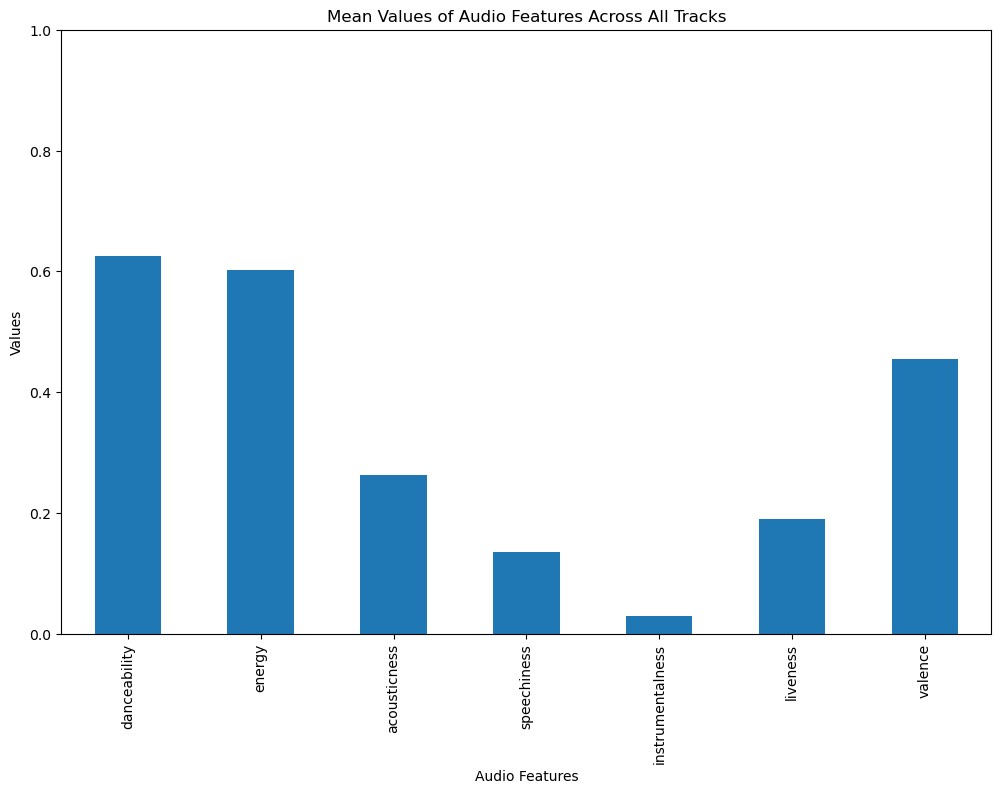

In [25]:
feature_bars = df4[['danceability', 'energy', 'acousticness', 'speechiness', 'instrumentalness', 'liveness', 'valence']]
feature_bars.mean().plot.bar()
plt.title('Mean Values of Audio Features Across All Tracks')
plt.ylim(0, 1) 
plt.xlabel('Audio Features')
plt.ylabel('Values')
plt.savefig('../viz/pyplots/MeanAudioFeaturesBarPlot.png')

#### Violin plot of feature distribution

In [26]:
columns = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature', 'valence']
features_df = df5[columns]

Scale feature distribution to match the 0-1 scale of other features

In [27]:
for col in ['loudness', 'tempo', 'key', 'time_signature']:
    features_df[col] = ((features_df[col] - features_df[col].min()) / (features_df[col].max() - features_df[col].min()))
scaled_data = features_df 
scaled_data

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence
35,0.33500,0.563,0.664,0.000000,0.818182,0.0849,0.806414,0.1540,0.689750,0.75,0.688
501,0.08880,0.824,0.764,0.002940,0.454545,0.1170,0.845283,0.0854,0.345896,0.75,0.881
8218,0.16400,0.336,0.627,0.000000,0.636364,0.0708,0.698215,0.0384,0.592569,0.75,0.350
505,0.30400,0.664,0.609,0.000000,0.090909,0.0926,0.740887,0.0707,0.474516,0.75,0.194
6104,0.00614,0.737,0.846,0.000000,0.090909,0.0486,0.830299,0.2200,0.229098,0.75,0.546
...,...,...,...,...,...,...,...,...,...,...,...
5989,0.19100,0.637,0.431,0.000000,0.545455,0.1080,0.674599,0.0297,0.532673,0.75,0.151
5988,0.17400,0.569,0.560,0.000005,0.272727,0.0863,0.702330,0.0342,0.194211,0.75,0.413
5987,0.07210,0.691,0.816,0.000000,0.090909,0.1410,0.803775,0.0549,0.322766,0.75,0.654
5986,0.20500,0.691,0.948,0.000000,0.545455,0.3030,0.848012,0.0539,0.509724,0.75,0.874


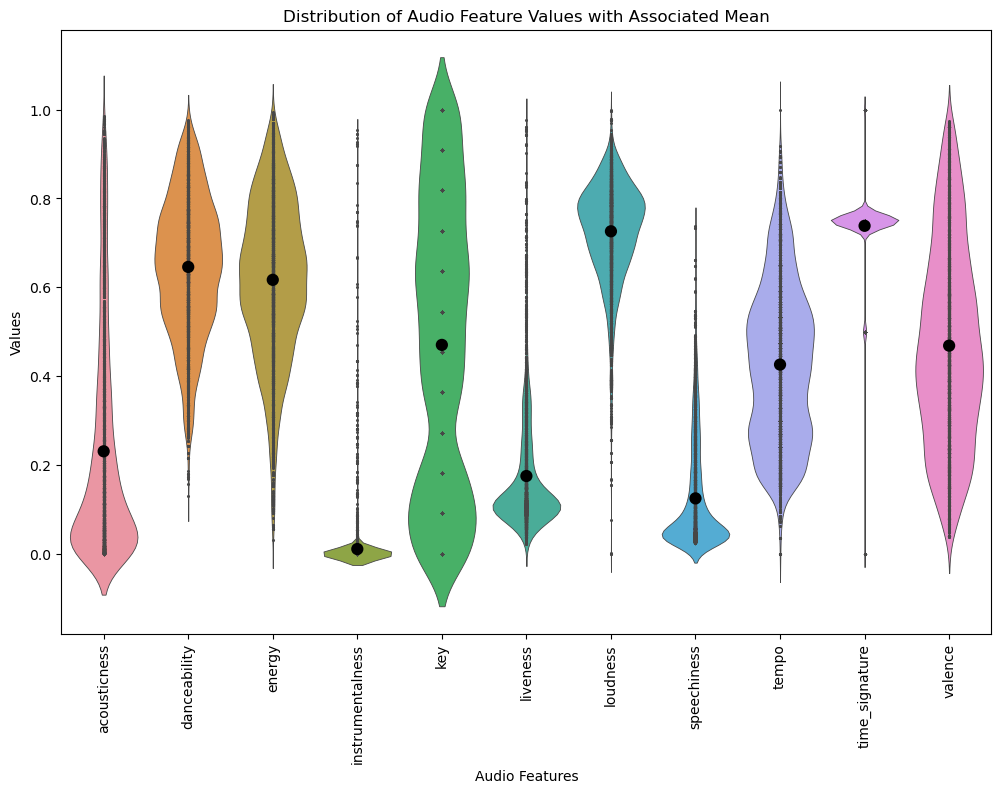

<Figure size 1200x800 with 0 Axes>

In [28]:
features_melt = features_df.melt(var_name='groups', value_name='vals')
ax = sns.violinplot(x="groups", y="vals", data=features_melt, linewidth = 0.6, inner = 'point', scale= 'width')
sns.pointplot(x = "groups", y="vals", data=features_melt, estimator = mean, color="black", linestyles="", ci=None)
plt.xticks(rotation='vertical')
plt.title('Distribution of Audio Feature Values with Associated Mean')
plt.xlabel('Audio Features')
plt.ylabel('Values')
plt.show()
plt.savefig('../viz/pyplots/ViolinDistofAudioFeatureValues.png')

#### Violin plot of valence by genre

In [29]:
vg_columns = ['main_genre', 'valence']
vg_df = df5[vg_columns]
vg_df

,main_genre,valence
35,Pop,0.688
501,Pop,0.881
8218,Pop,0.350
505,Pop,0.194
6104,Hip-hop,0.546
...,...,...
5989,Country,0.151
5988,Country,0.413
5987,Country,0.654
5986,Country,0.874


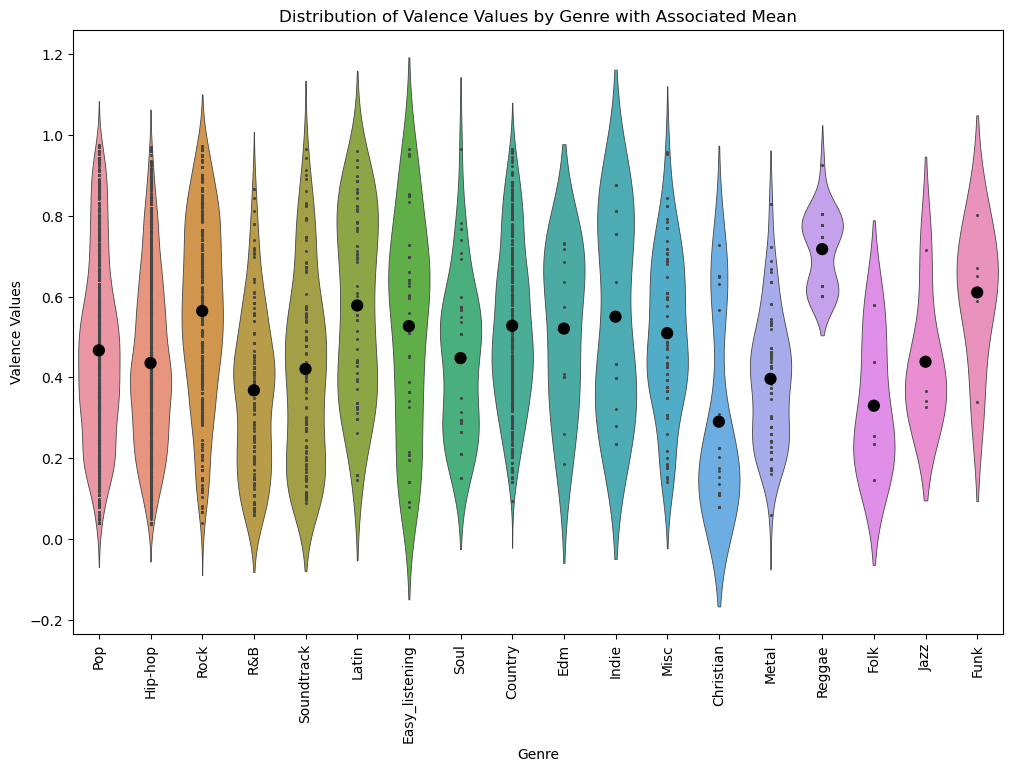

<Figure size 1200x800 with 0 Axes>

In [30]:
ax = sns.violinplot(x="main_genre", y="valence", data=vg_df, linewidth = 0.6, inner = 'point', scale= 'width')
sns.pointplot(x = "main_genre", y="valence", data=vg_df, estimator = mean, color="black", linestyles="", ci=None)
plt.xticks(rotation='vertical')
plt.title('Distribution of Valence Values by Genre with Associated Mean')
plt.xlabel('Genre')
plt.ylabel('Valence Values')
plt.show()
plt.savefig('../viz/pyplots/ViolinDistofValenceValuesbyGenre.png')

#### Mean valence for most popular album tracks all chart years together: 

In [43]:
print(f"Mean valence for all years: {np.mean(df5['valence'])} dB\n")

Mean valence for all years: 0.46869520258012504 dB



#### Scatter plot of track popularity compared to valence

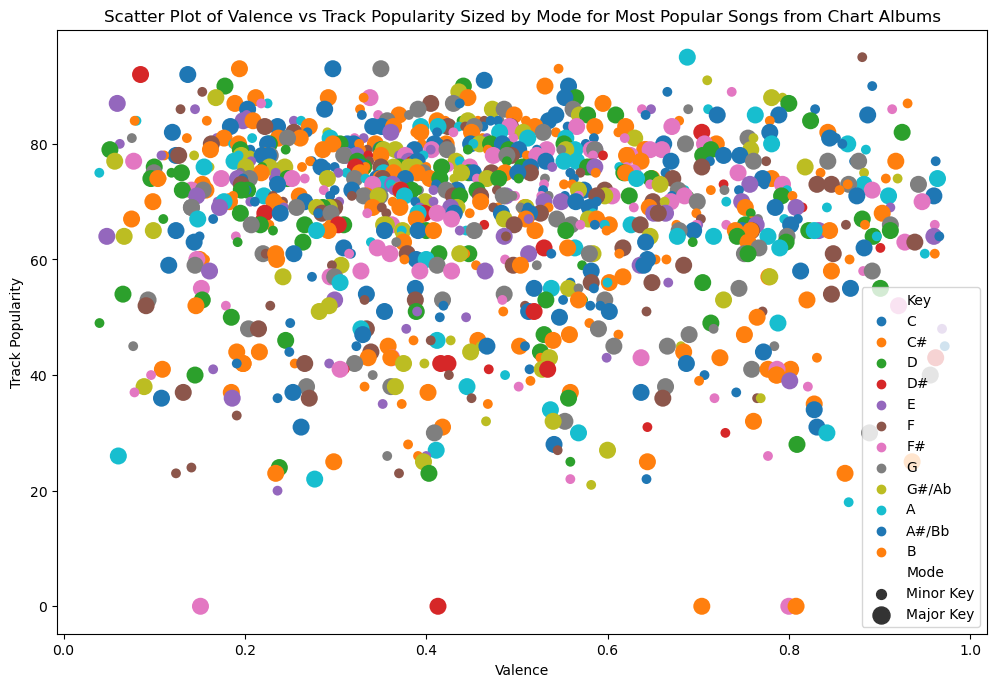

In [31]:
sns.scatterplot(x="valence", y="track_popularity",
                hue="key",
                size="mode",
                palette="tab10",
                sizes=(150, 50), linewidth=0,
                data= df5[df5['playlist_name'] == 'Billboard 200 Top Albums 2021'])
plt.title('Scatter Plot of Valence vs Track Popularity Sized by Mode for Most Popular Songs from Chart Albums')
plt.xlabel('Valence')
plt.ylabel('Track Popularity')
vpm_plot_key=plt.legend()
vpm_plot_key.get_texts()[0].set_text('Key')
vpm_plot_key.get_texts()[1].set_text('C')
vpm_plot_key.get_texts()[2].set_text('C#')
vpm_plot_key.get_texts()[3].set_text('D')
vpm_plot_key.get_texts()[4].set_text('D#')
vpm_plot_key.get_texts()[5].set_text('E')
vpm_plot_key.get_texts()[6].set_text('F')
vpm_plot_key.get_texts()[7].set_text('F#')
vpm_plot_key.get_texts()[8].set_text('G')
vpm_plot_key.get_texts()[9].set_text('G#/Ab')
vpm_plot_key.get_texts()[10].set_text('A')
vpm_plot_key.get_texts()[11].set_text('A#/Bb')
vpm_plot_key.get_texts()[12].set_text('B')
vpm_plot_key.get_texts()[13].set_text('Mode')
vpm_plot_key.get_texts()[14].set_text('Minor Key')
vpm_plot_key.get_texts()[15].set_text('Major Key')
plt.savefig('../viz/pyplots/ValencePopularityModeScatterPlot.png')

#### Average loudness for all chart years together: 

In [32]:
print(f"Average loudness for all years: {np.mean(df5['loudness'])} dB\n")

Average loudness for all years: -6.838704091916974 dB



#### Average loudness for each chart year: 

In [36]:
print(f"Average loudness in 2017: {np.mean(df5[df5['playlist_name'] == 'Billboard 200 Top Albums 2017']['loudness'])} dB")
print(f"Average loudness in 2018: {np.mean(df5[df5['playlist_name'] == 'Billboard 200 Top Albums 2018']['loudness'])} dB")
print(f"Average loudness in 2019: {np.mean(df5[df5['playlist_name'] == 'Billboard 200 Top Albums 2019']['loudness'])} dB")
print(f"Average loudness in 2020: {np.mean(df5[df5['playlist_name'] == 'Billboard 200 Top Albums 2020']['loudness'])} dB")
print(f"Average loudness in 2021: {np.mean(df5[df5['playlist_name'] == 'Billboard 200 Top Albums 2021']['loudness'])} dB")

Average loudness in 2017: -6.7468917525773096 dB
Average loudness in 2018: -6.69637085427135 dB
Average loudness in 2019: -6.836943775100402 dB
Average loudness in 2020: -6.871790999999998 dB
Average loudness in 2021: -7.0380499999999895 dB


In [37]:
loudness_frame = df5[['track_id', 'playlist_name', 'main_genre', 'loudness', 'energy']]
average_loudness = list(loudness_frame.groupby('playlist_name')['loudness'].mean())
average_loudness

[-6.7468917525773096,
 -6.69637085427135,
 -6.836943775100402,
 -6.871790999999998,
 -7.0380499999999895]

#### Chart of change in average loudness over time

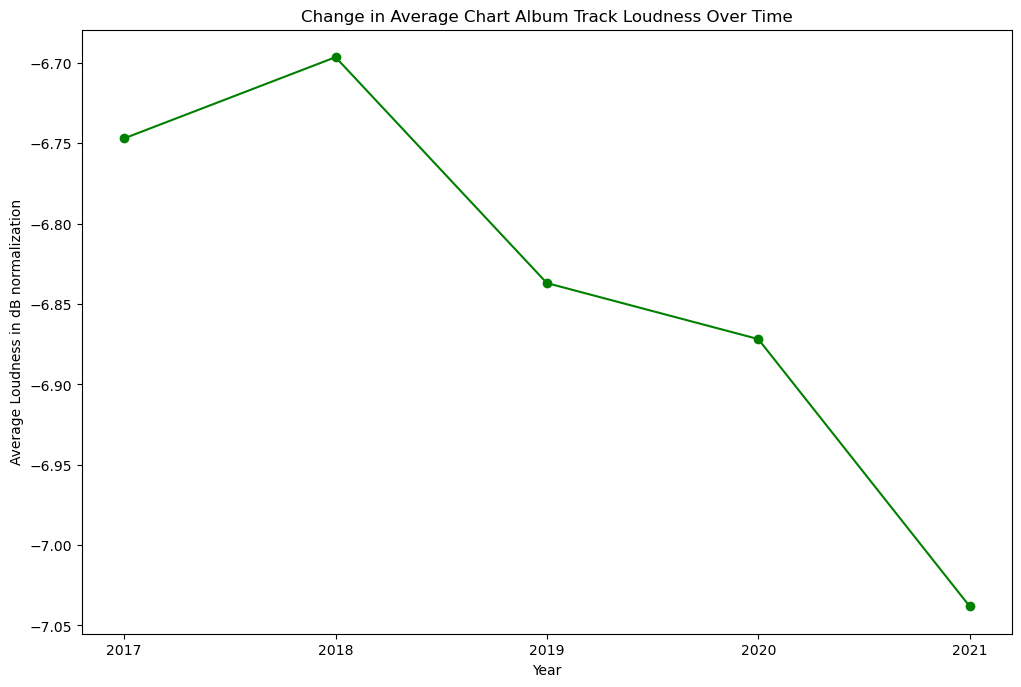

<Figure size 1200x800 with 0 Axes>

In [38]:
years = [2017, 2018, 2019, 2020, 2021]
plt.plot(years, average_loudness, color='green', marker='o', linestyle='solid')
plt.title("Change in Average Chart Album Track Loudness Over Time")
plt.xlabel("Year")
plt.ylabel("Average Loudness in dB normalization")
plt.xticks(np.arange(min(years), max(years)+1, 1.0))
plt.show()
plt.savefig('../viz/pyplots/LoudnessMeansOverTimeLineChart.png')

#### Error bar of loudness by genre

In [41]:
# create new table
all_genre_features_table = df5[['track_name', 'track_id', 'main_genre', 'loudness', 'valence']]
# grouping loudness by genre
genre_loudness = all_genre_features_table.groupby('main_genre')['loudness'].aggregate(['min', np.mean, 'max'])
# merge
genre_loudness_error = pd.merge(all_genre_features_table, genre_loudness, how='left', left_on='main_genre', right_on = 'main_genre', copy=False).fillna(0)

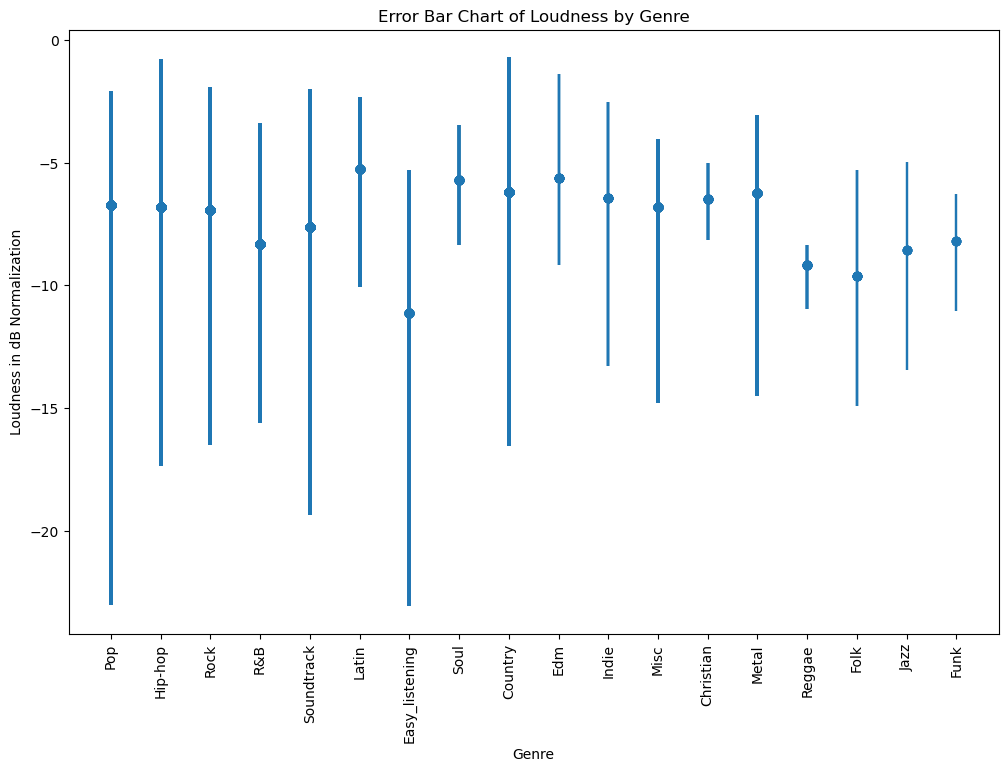

<Figure size 1200x800 with 0 Axes>

In [42]:
# Plot
plt.errorbar(genre_loudness_error["main_genre"],genre_loudness_error["mean"], [genre_loudness_error["mean"] - genre_loudness_error['min'],genre_loudness_error['max']-genre_loudness_error["mean"]], linestyle='None',marker='o')
plt.xticks(rotation='vertical')
plt.title('Error Bar Chart of Loudness by Genre')
plt.xlabel('Genre')
plt.ylabel('Loudness in dB Normalization')
plt.show()
plt.savefig('../viz/pyplots/LoudnessbyGenreErrorChart.png')

#### Count plot for songs in each major and minor key

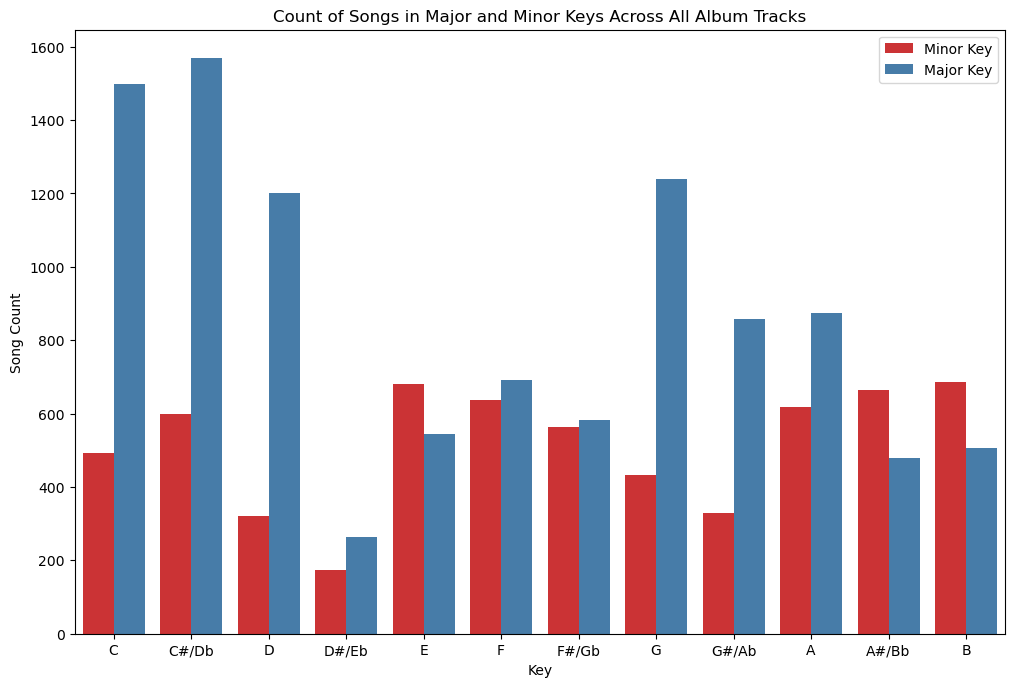

In [44]:
key_plot = sns.countplot(data=df4, x='key', hue='mode', palette = 'Set1')
plt.xlabel('Key')
plt.ylabel('Song Count')
plt.title('Count of Songs in Major and Minor Keys Across All Album Tracks')
key_plot.set_xticklabels(['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G', 'G#/Ab', 'A', 'A#/Bb', 'B'])
plot_modes=plt.legend()
plot_modes.get_texts()[0].set_text('Minor Key')
plot_modes.get_texts()[1].set_text('Major Key')
plt.savefig('../viz/pyplots/KeyCountPlot.png')

#### Number of tracks with explicit lyrics

In [46]:
df5['track_explicit'].value_counts()

False    3040
True     1921
Name: track_explicit, dtype: int64

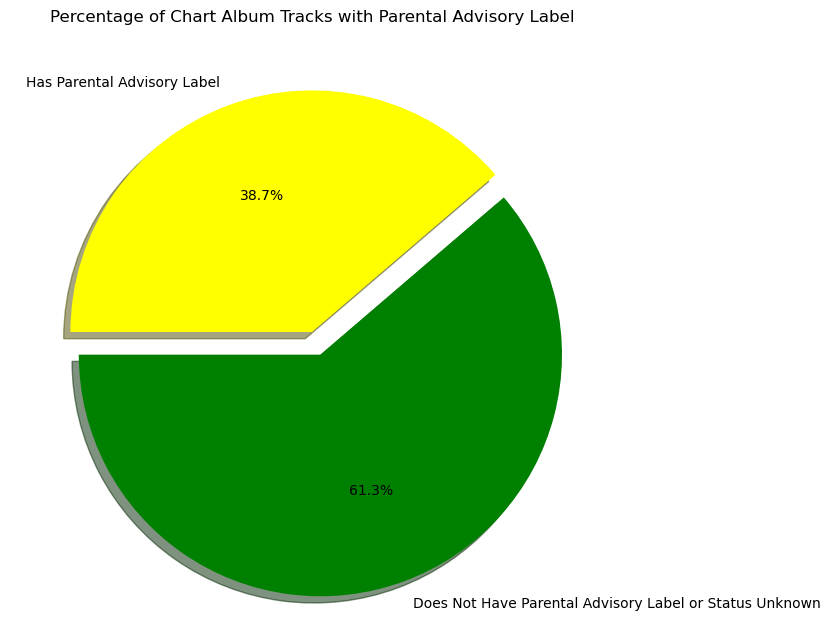

In [48]:
plt.pie(df5['track_explicit'].value_counts(), 
        explode=(0.1, 0), 
        colors=['green', 'yellow'], 
        autopct='%1.1f%%',
        shadow=True,
        startangle=180, labels = ['Does Not Have Parental Advisory Label or Status Unknown', 'Has Parental Advisory Label']);
plt.title('Percentage of Chart Album Tracks with Parental Advisory Label')
plt.savefig('../viz/pyplots/ExplicitPieChart.png')

#### Album Count with Parental Advisory Labels by Year

In [49]:
# Slice dataset
exp_year = df5[['playlist_name', 'track_explicit']]
#Dummy code the explicit column
exp_year_dummy = pd.get_dummies(exp_year, prefix='exp', columns=['track_explicit'])
# Create grouped df
exp_year_dummy_grouped = exp_year_dummy.groupby(
     ['playlist_name']
 ).agg(
     not_exp = ('exp_False','sum'),
     exp = ('exp_True','sum'),
 ).reset_index()
exp_year_dummy_grouped

,playlist_name,not_exp,exp
0,Billboard 200 Top Albums 2017,625.0,345.0
1,Billboard 200 Top Albums 2018,614.0,381.0
2,Billboard 200 Top Albums 2019,586.0,410.0
3,Billboard 200 Top Albums 2020,601.0,399.0
4,Billboard 200 Top Albums 2021,614.0,386.0


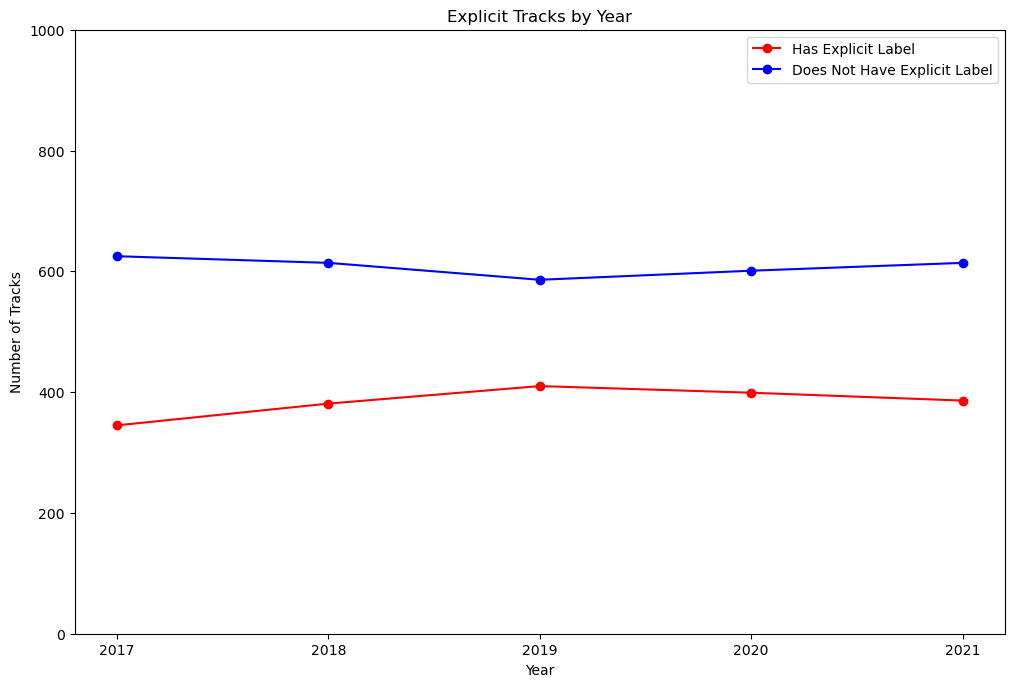

In [51]:
# Create stacked bar chart
exp_count = list(exp_year_dummy_grouped['exp'])
not_exp_count = list(exp_year_dummy_grouped['not_exp'])
plt.plot(years, exp_count, color='red', marker='o', linestyle='solid', label = "Has Explicit Label")
plt.plot(years, not_exp_count, color='blue', marker='o', linestyle='solid', label = "Does Not Have Explicit Label")
plt.ylim([0, 1000])
plt.xticks (ticks = years)
plt.legend()
plt.title("Explicit Tracks by Year")
plt.xlabel("Year")
plt.ylabel("Number of Tracks")
plt.savefig('../viz/pyplots/ExpYearLineChart.png')

#### Stacked to 100% (filled) bar chart 

In [52]:
plotdata = exp_year_dummy_grouped.set_index('playlist_name')
plotdata.head()

,not_exp,exp
playlist_name,,
Billboard 200 Top Albums 2017,625.0,345.0
Billboard 200 Top Albums 2018,614.0,381.0
Billboard 200 Top Albums 2019,586.0,410.0
Billboard 200 Top Albums 2020,601.0,399.0
Billboard 200 Top Albums 2021,614.0,386.0


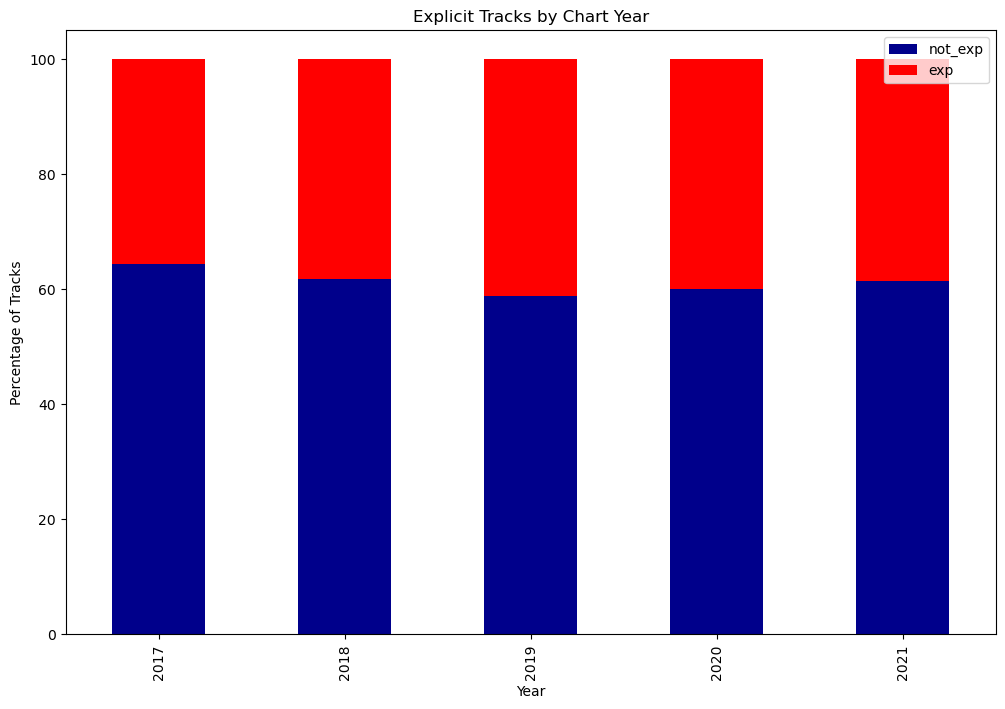

In [53]:
stacked_data = plotdata.apply(lambda x: x*100/sum(x), axis=1)
labels = list(['2017', '2018', '2019', '2020', '2021'])
ax = stacked_data.plot(kind='bar', stacked=True, color=['darkblue', 'red'])
ax.set(xticklabels = (labels))
plt.title("Explicit Tracks by Chart Year")
plt.xlabel("Year")
plt.ylabel("Percentage of Tracks")
plt.savefig('../viz/pyplots/ExpYearFilledBarChart.png')

#### Explicit Lyrics by Genre

In [54]:
# Slice dataset
exp_track = df5[['main_genre', 'track_explicit']]
#Dummy code the explicit column
exp_dummy = pd.get_dummies(exp_track, prefix='exp', columns=['track_explicit'])
# Create grouped df
exp_dummy_grouped = exp_dummy.groupby(
     ['main_genre']
 ).agg(
     not_exp = ('exp_False','sum'),
     exp = ('exp_True','sum'),
 ).reset_index()

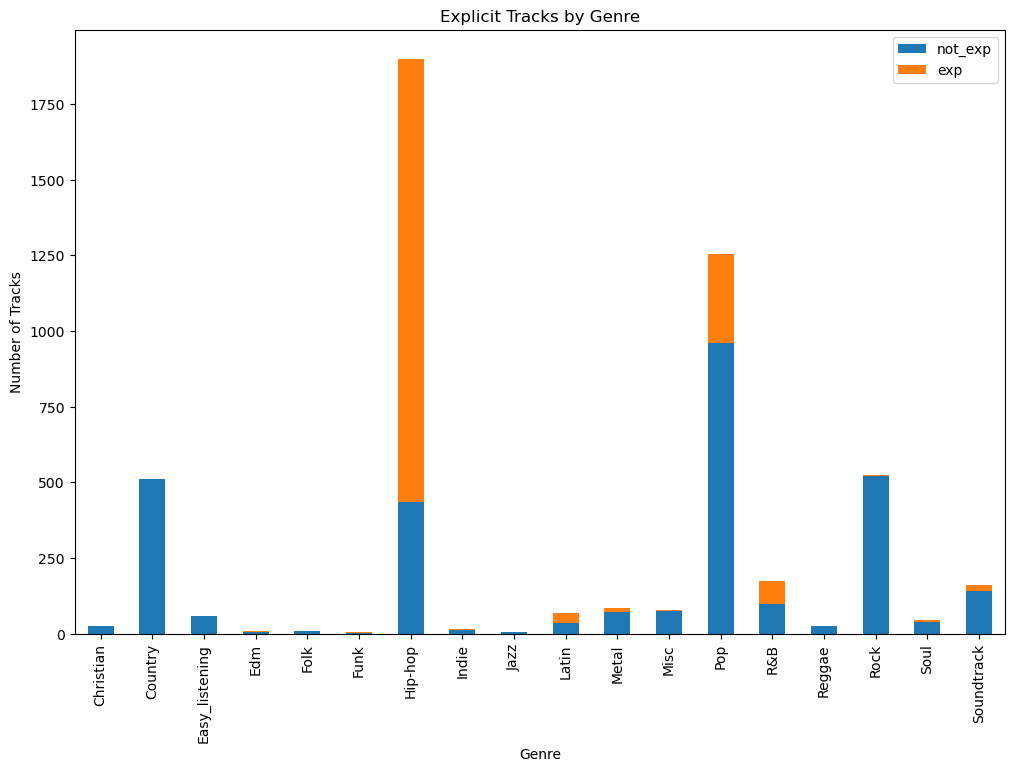

In [55]:
# Create stacked bar chart
labels = list(exp_dummy_grouped['main_genre'])
ax = exp_dummy_grouped.plot(kind='bar', stacked=True)
ax.set(xticklabels = (labels))
plt.title("Explicit Tracks by Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Tracks")
plt.savefig('../viz/pyplots/ExpGenreStackedBarChart.png')

#### Stacked to 100% (filled) bar chart 

In [56]:
plotdata = exp_dummy_grouped.set_index('main_genre')

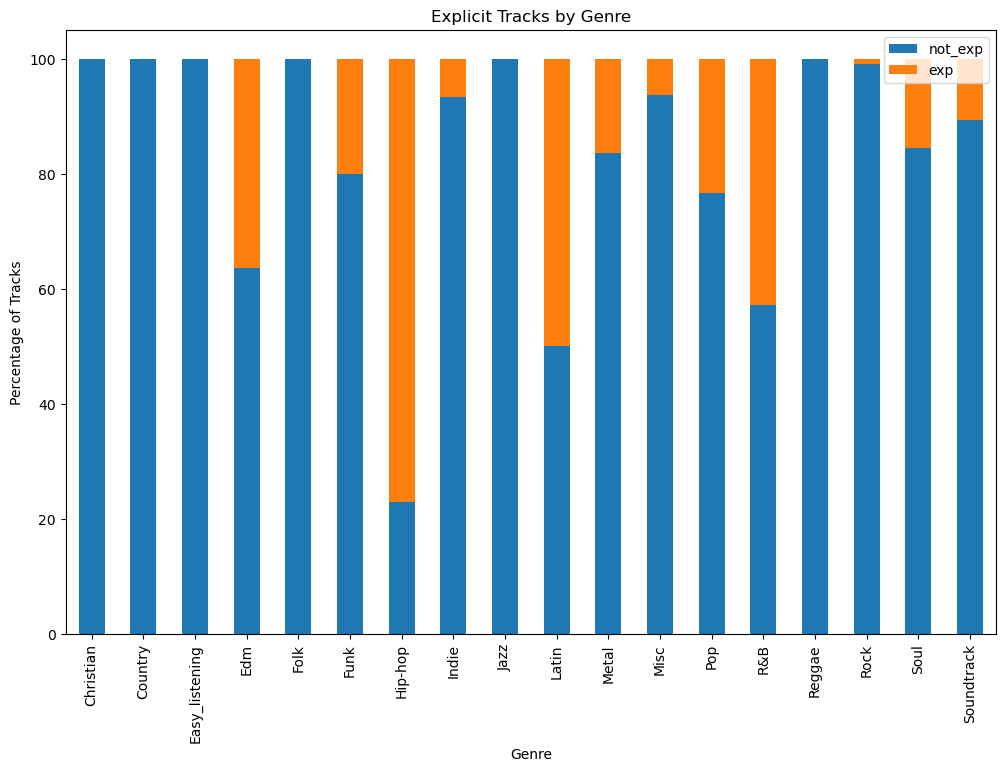

In [57]:
stacked_data = plotdata.apply(lambda x: x*100/sum(x), axis=1)
labels = list(exp_dummy_grouped['main_genre'])
ax = stacked_data.plot(kind='bar', stacked=True)
ax.set(xticklabels = (labels))
plt.title("Explicit Tracks by Genre")
plt.xlabel("Genre")
plt.ylabel("Percentage of Tracks")
plt.savefig('../viz/pyplots/ExpGenreFilledBarChart.png')

#### Histograms of audio features

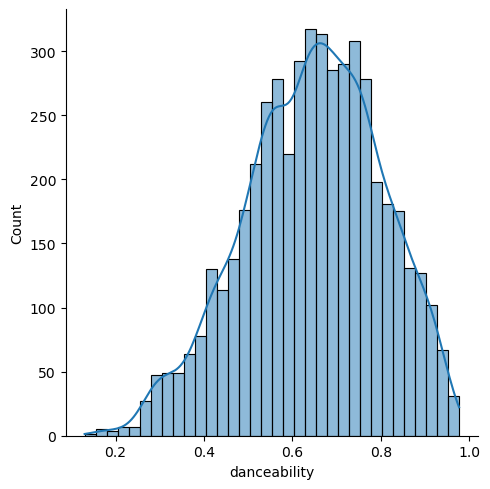

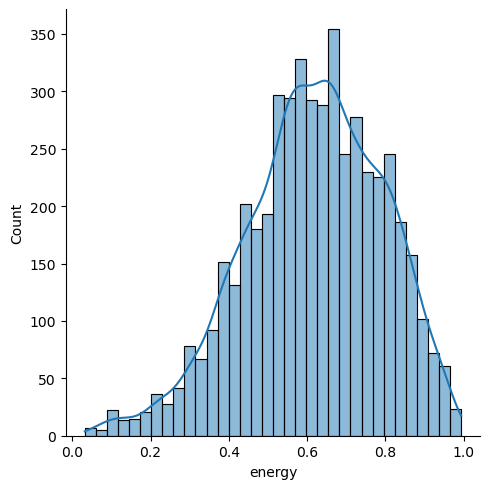

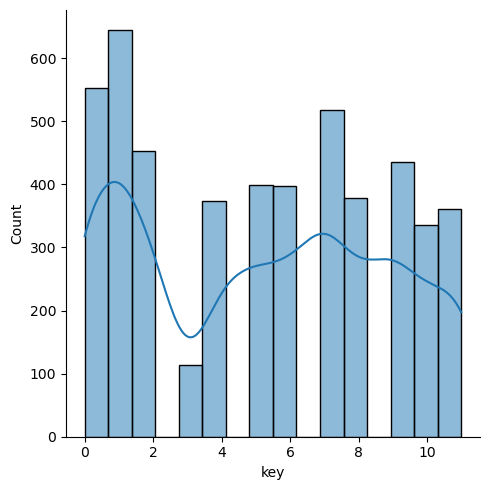

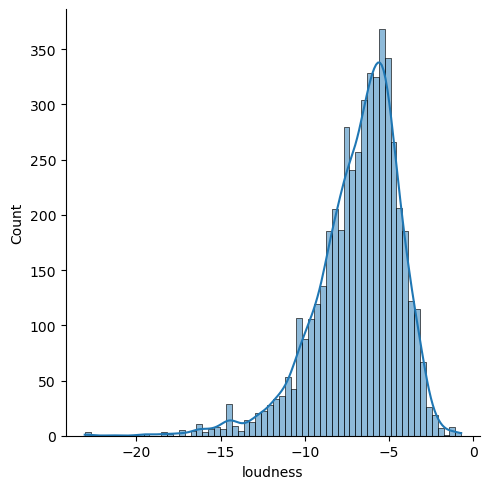

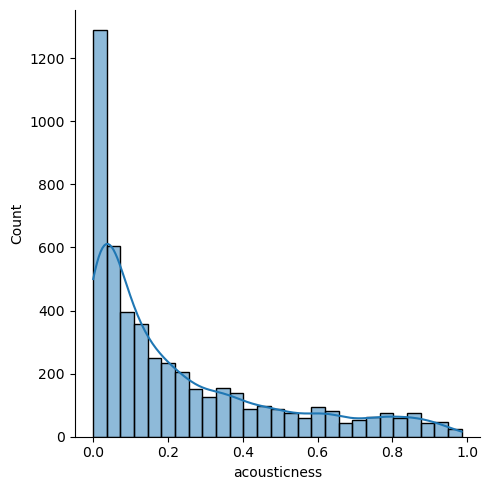

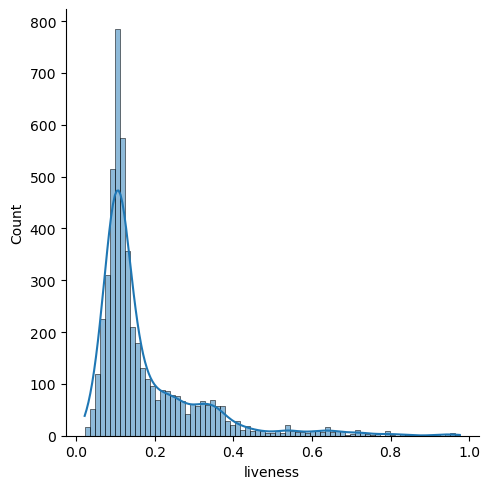

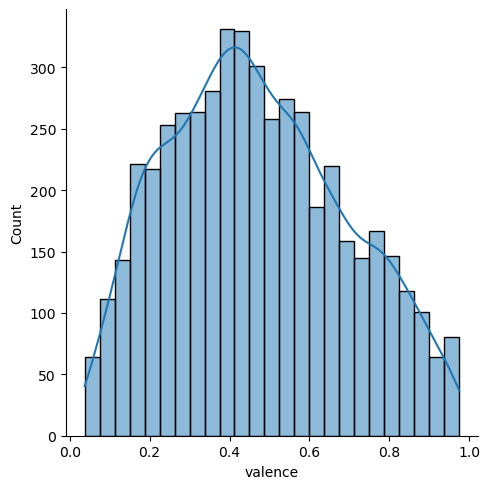

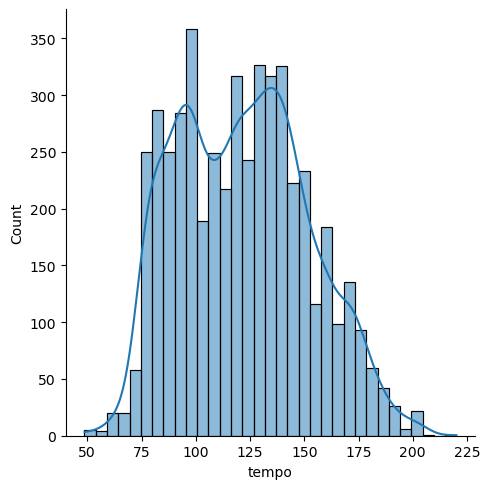

In [58]:
features = ['danceability', 'energy', 'key', 'loudness', 'acousticness', 'liveness', 'valence','tempo']
for col in features:
  sns.displot(df5, x=col, kde=True)
  plt.show()

#### Correlation Heatmap of Features

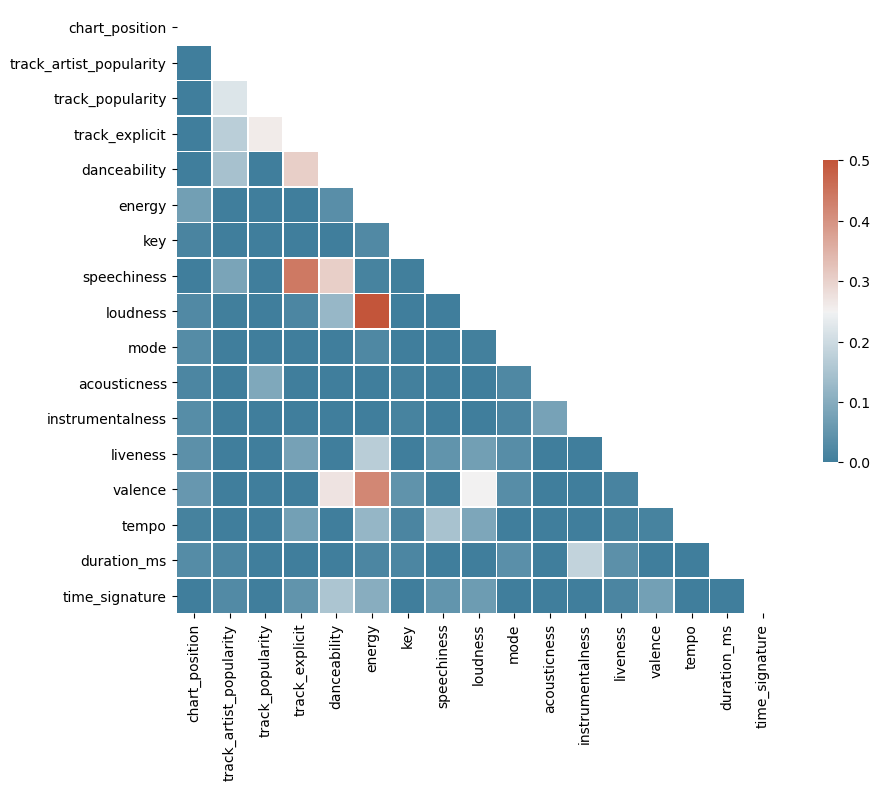

In [60]:
# Dataframe with audio features
track_feature_corr = df5[['playlist_name', 'chart_position', 'track_artist_popularity', 'track_popularity', 'track_explicit', 'danceability', 'energy', 'key', 'speechiness', 'loudness', 'mode', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]

# Generate a mask for the upper part of the chart
mask = np.triu(np.ones_like(track_feature_corr.corr(), dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Can add mask=mask in sns.heatmap to mask top triangle of plot. Removed to view entire plot.
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(track_feature_corr.corr(), cmap=cmap, vmin=0, mask=mask, vmax=.5, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('../viz/pyplots/CorrHeatMapAllTracks.png')

#### Average song length

In [67]:
print(f"Average song duration in minutes for all years: {int(np.mean(df5['duration_ms']) // 60000)}:" f"{round(np.mean(df5['duration_ms'] / 10000) % 60)} \n")

Average song duration in minutes for all years: 3:22 



In [68]:
print(f"Average song duration in minutes for all years: {int(np.mean(df5['duration_ms']) // 60000)}:" f"{round(np.mean(df5['duration_ms'] / 10000) % 60)} \n")

Average song duration in minutes for all years: 3:22 



#### Longest song from entire track dataset

In [69]:
print(f"Longest song in minutes: {df4.iloc[df4['duration_ms'].idxmax()]['track_name']} by "
        f"{df4.iloc[df4['duration_ms'].idxmax()]['track_artist']}, length = "
        f"{int(df4['duration_ms'].max() // 60000)}:" f"{round((df4['duration_ms'].max() / 10000) % 60)}\n")

Longest song in minutes: Like I Never Left (feat. Diddy & Ludacris, feat. Pharrell, Pusha T & Casino) by Future, length = 25:35



#### Artist that has the most appearances on charts across the entire dataset year range

In [71]:
df_freq_art = df2.dropna(subset=['album_artist'])
print(f"Most frequently appearing album artist: {df_freq_art['album_artist'].value_counts().idxmax()}" f" appears {df_freq_art['album_artist'].value_counts().max()} times.\n")

Most frequently appearing album artist: Drake appears 31 times.



#### Number of chart appearances by particular artists:

In [72]:
print("Number of chart appearances of albums by Taylor Swift: " + str(df2['album_artist'].str.contains("Taylor Swift").sum()))
print("Number of chart appearances of albums by Queen: " + str(df2['album_artist'].str.contains("Queen").sum()))
print("Number of chart appearances of albums by Elton John: " + str(df2['album_artist'].str.contains("Elton John").sum()))

Number of chart appearances of albums by Taylor Swift: 15
Number of chart appearances of albums by Queen: 7
Number of chart appearances of albums by Elton John: 4


#### Create word cloud viz of artist chart appearance frequency

Create df of artist frequencies

In [73]:
album_artist_chart_count = df2['album_artist'].value_counts()
album_artist_chart_count = album_artist_chart_count.reset_index()
album_artist_chart_count.columns = ['artist_name', 'artist_chart_frequency'] # change column names

Convert df to dict

In [74]:
artist_freq = dict(zip(album_artist_chart_count['artist_name'].tolist(), album_artist_chart_count['artist_chart_frequency'].tolist()))

Plot word cloud

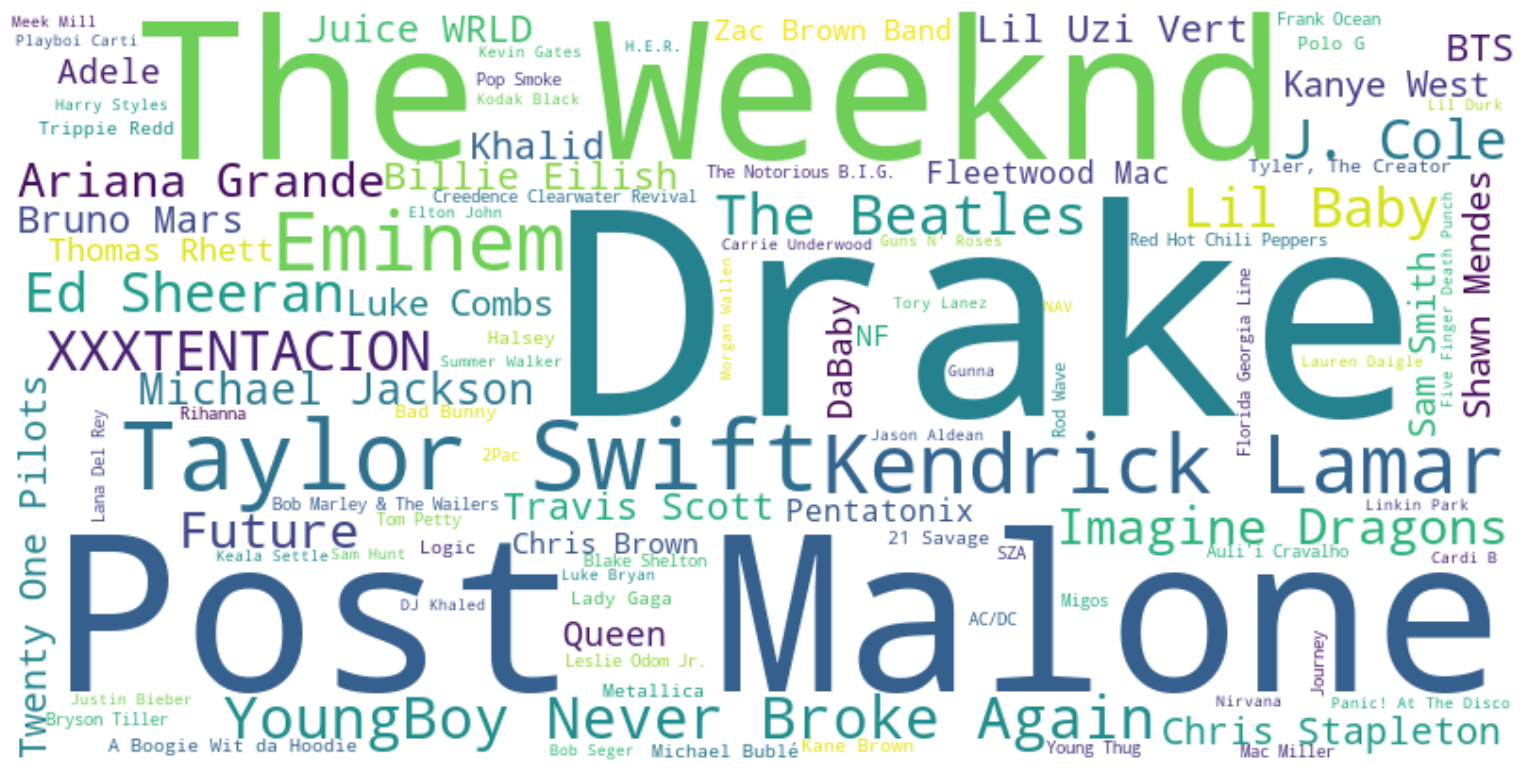

In [75]:
wc_white = WordCloud(background_color='white',width=800, height=400, max_words=100).generate_from_frequencies(artist_freq)
plt.figure(figsize=(20, 10))
plt.imshow(wc_white, interpolation='bilinear')
plt.axis('off')
plt.show()
# Plot visualizations must be saved manually as png, but can be exported to svg with the following:
# wordcloud_svg = wc_white.to_svg(embed_font=True)
# f = open("../viz/pyplots/ArtistChartAppearanceWordCloudWhite.svg","w+")
# f.write(wordcloud_svg )
# f.close()

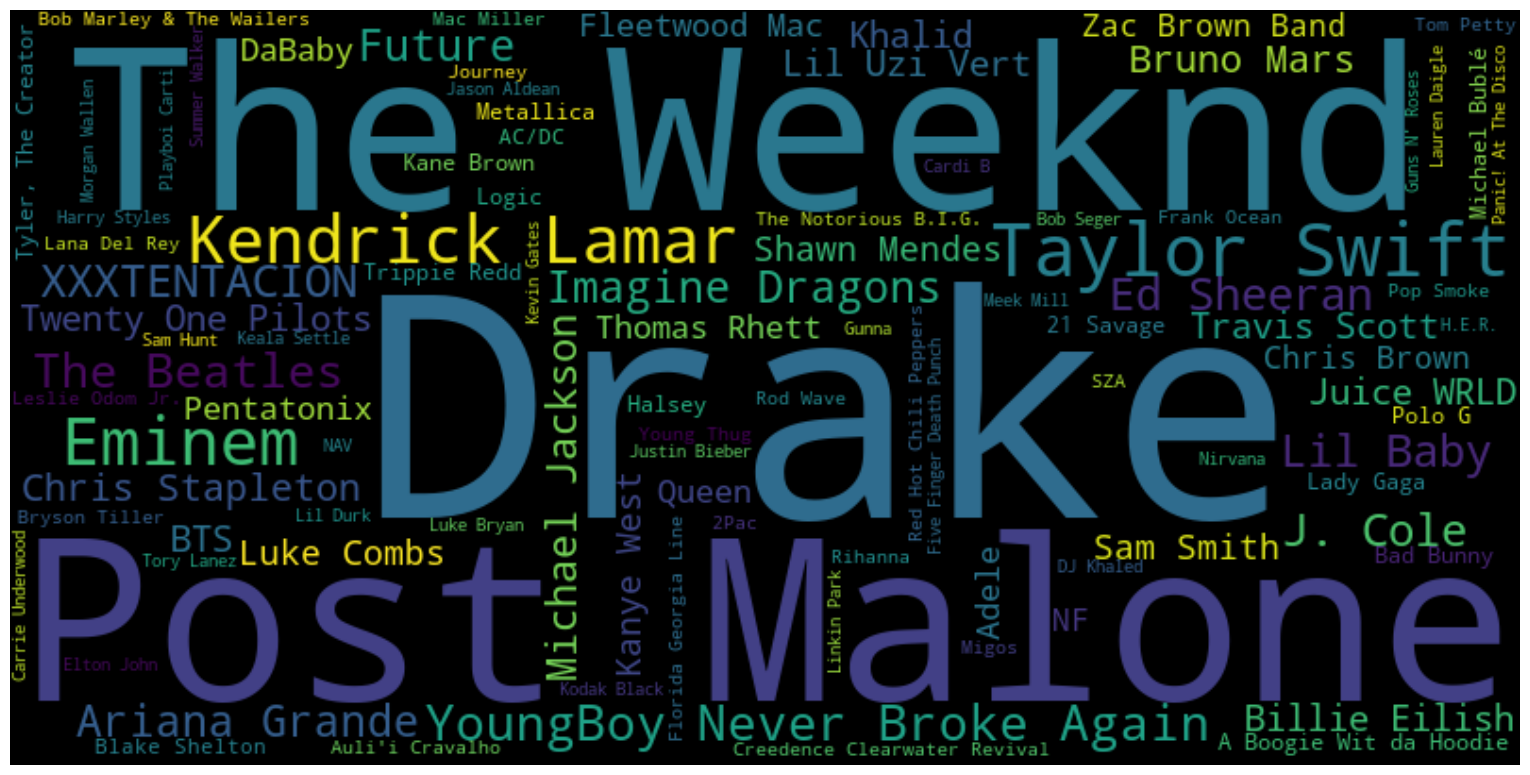

In [76]:
wc_black = WordCloud(background_color='black',width=800, height=400, max_words=100).generate_from_frequencies(artist_freq)
plt.figure(figsize=(20, 10))
plt.imshow(wc_black, interpolation='bilinear')
plt.axis('off')
plt.show()
# Plot visualizations must be saved manually as png, but can be exported to svg with the following:
# wordcloud_svg = wc_black.to_svg(embed_font=True)
# f = open("../viz/pyplots/ArtistChartAppearanceWordCloudBlack.svg","w+")
# f.write(wordcloud_svg )
# f.close()

#### Queen songs appearances on all charts

In [77]:
df2.loc[df2['album_artist'] == "Queen"]

,Unnamed: 0,playlist_id,playlist_name,position,album_name,album_id,album_release_date,album_artists,album_artists_ids,album_artists_genres,album_artists_popularity,album_artists_followers,track_name,track_id,track_popularity,track_artists,track_artists_ids,track_artists_genres,track_artists_popularity,track_explicit,track_artists_followers,danceability,energy,key,speechiness,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,album_artist,release_date_datetime,release_year,chart_position
22,22,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,23,Greatest Hits,6a8nlV9V8kPUbTTCJNVSsh,2014,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[88],[39227023],Bohemian Rhapsody - Remastered 2011,6ljkRMigoNtu0x1mlTEsKc,36,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[88],False,[39227023],0.393,0.398,0,0.0514,-9.973,0,0.256,0.000000,0.195,0.2360,143.353,355467,4,Queen,2014-01-01,2014,23
224,224,1EEazdcjH0keT4sttGvH8c,Billboard 200 Top Albums 2020,25,Greatest Hits,6a8nlV9V8kPUbTTCJNVSsh,2014,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[88],[39227023],Bohemian Rhapsody - Remastered 2011,6ljkRMigoNtu0x1mlTEsKc,36,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[88],False,[39227023],0.393,0.398,0,0.0514,-9.973,0,0.256,0.000000,0.195,0.2360,143.353,355467,4,Queen,2014-01-01,2014,25
411,411,0n3V7u9sMRV7sCDMhWxDtL,Billboard 200 Top Albums 2019,12,Bohemian Rhapsody (The Original Soundtrack),3BHe7LbW5yRjyqXNJ3A6mW,2018-10-19,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[88],[39227023],The Show Must Go On - 2011 Remaster,0LCWyLFPXIeg1CIC1NS712,40,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[88],False,[39227023],0.425,0.675,11,0.0409,-6.790,0,0.433,0.000005,0.112,0.0671,84.156,271612,4,Queen,2018-10-19,2018,12
426,426,0n3V7u9sMRV7sCDMhWxDtL,Billboard 200 Top Albums 2019,27,Greatest Hits,6a8nlV9V8kPUbTTCJNVSsh,2014,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[88],[39227023],Bohemian Rhapsody - Remastered 2011,6ljkRMigoNtu0x1mlTEsKc,36,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[88],False,[39227023],0.393,0.398,0,0.0514,-9.973,0,0.256,0.000000,0.195,0.2360,143.353,355467,4,Queen,2014-01-01,2014,27
479,479,0n3V7u9sMRV7sCDMhWxDtL,Billboard 200 Top Albums 2019,80,The Platinum Collection (Greatest Hits I II & ...,60Yx1xATvlWpAMzsBMMTSE,2011,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[88],[39227023],Bohemian Rhapsody - Remastered 2011,4q0ga6PujERMThC4FXO4WV,31,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[88],False,[39227023],0.392,0.398,0,0.0515,-9.973,0,0.256,0.000000,0.195,0.2360,143.587,355467,4,Queen,2011-01-01,2011,80
695,695,34KSLHLGSNqeK6UfxKnLuM,Billboard 200 Top Albums 2018,96,Greatest Hits,6a8nlV9V8kPUbTTCJNVSsh,2014,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[88],[39227023],Bohemian Rhapsody - Remastered 2011,6ljkRMigoNtu0x1mlTEsKc,36,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[88],False,[39227023],0.393,0.398,0,0.0514,-9.973,0,0.256,0.000000,0.195,0.2360,143.353,355467,4,Queen,2014-01-01,2014,96
932,932,1N9WQ0C6m7n1TVeLXdUoNb,Billboard 200 Top Albums 2017,135,The Platinum Collection (Greatest Hits I II & ...,60Yx1xATvlWpAMzsBMMTSE,2011,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[88],[39227023],Bohemian Rhapsody - Remastered 2011,4q0ga6PujERMThC4FXO4WV,31,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[88],False,[39227023],0.392,0.398,0,0.0515,-9.973,0,0.256,0.000000,0.195,0.2360,143.587,355467,4,Queen,2011-01-01,2011,135


#### Most popular Taylor Swift song on all charts

In [78]:
print("Most popular Taylor Swift song: " + str(df4.iloc[df4[df4['track_artist'].str.contains('Taylor Swift')]['track_popularity'].idxmax]['track_name']) + "\n")

Most popular Taylor Swift song: Lover



#### Oldest track

Wrangle release date format

In [79]:
# album_release_frame = df4[['track_name', 'track_artist', 'album_release_date', 'release_date_datetime', 'release_year']]
album_release_frame = df4[['album_release_date', 'track_name', 'track_artist']]
album_release_frame['datum'] = pd.to_datetime(album_release_frame['album_release_date'], format='%Y-%m-%d')
album_release_frame['year'] = album_release_frame['datum'].dt.year

In [80]:
print(f" The oldest track present on the charts is \"{album_release_frame.loc[album_release_frame['year'].idxmin()]['track_name']}\" released in {df2['album_release_date'].min()}.\n")

 The oldest track present on the charts is "The Christmas Song (Merry Christmas To You)" released in 1962.



In [81]:
# Recode newest date to string
date_time_str = album_release_frame.loc[album_release_frame['datum'].idxmax()]['datum'].strftime("%B %-d, %Y")
print(f" The newest track present on the charts is \"{album_release_frame.loc[album_release_frame['datum'].idxmax()]['track_name']}\" released by {album_release_frame.loc[album_release_frame['datum'].idxmax()]['track_artist']} on {date_time_str}.\n")


 The newest track present on the charts is "Bad Morning" released by YoungBoy Never Broke Again on October 5, 2021.



#### Bar chart of songs by release year

In [61]:
# grouping the songs by year to get the sum
release_year = album_release_frame.groupby('year', as_index=False)['track_name'].count()

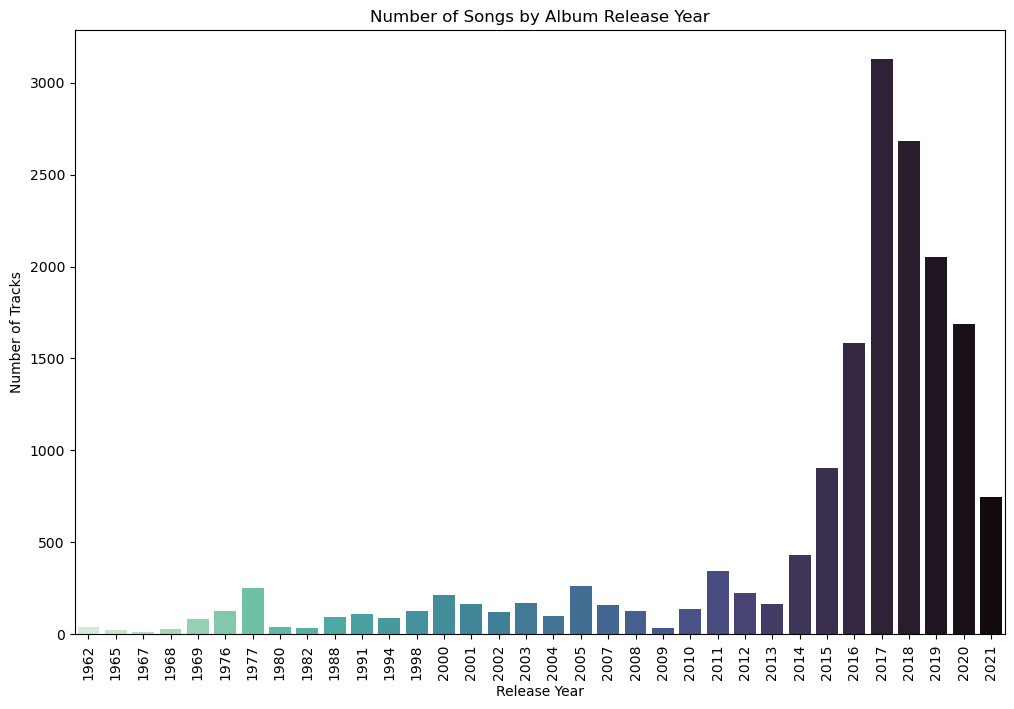

<Figure size 1200x800 with 0 Axes>

In [62]:
sns.barplot(data=release_year, x='year', y='track_name', palette='mako_r')
plt.xticks(rotation=90)
plt.title('Number of Songs by Album Release Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Tracks')
plt.show()
plt.savefig('../viz/pyplots/TracksPerReleaseYearBarChart.png')

#### Genre changes from year to year

Create new df with chart year recoded

In [84]:
df6 = df2
# create a list of conditions for recoding 
conditions = [
    (df6['playlist_name'] == "Billboard 200 Top Albums 2021"),
    (df6['playlist_name'] == "Billboard 200 Top Albums 2020"),
    (df6['playlist_name'] == "Billboard 200 Top Albums 2019"),
    (df6['playlist_name'] == "Billboard 200 Top Albums 2018"),
    (df6['playlist_name'] == "Billboard 200 Top Albums 2017")
    ]

# create a list of the values we want to assign for each condition
values = ['2021', '2020', '2019', '2018', '2017']

# create a new column and use np.select to assign values to it using our lists as arguments
df6['chart_year'] = np.select(conditions, values)

# display updated DataFrame
df6.head()

,Unnamed: 0,playlist_id,playlist_name,position,album_name,album_id,album_release_date,album_artists,album_artists_ids,album_artists_genres,album_artists_popularity,album_artists_followers,track_name,track_id,track_popularity,track_artists,track_artists_ids,track_artists_genres,track_artists_popularity,track_explicit,track_artists_followers,danceability,energy,key,speechiness,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,album_artist,release_date_datetime,release_year,chart_position,chart_year
0,0,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,1,Dangerous: The Double Album,1qW1C4kDOXnrly22daHbxz,2021-01-08,Morgan Wallen,['4oUHIQIBe0LHzYfvXNW4QM'],[['contemporary country']],[86],[2789002],More Than My Hometown,65mMCEOu5Ll1DBAfEUmerU,34,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],[['contemporary country']],[86],False,[2789002],0.621,0.868,6,0.0460,-5.478,1,0.617000,0.000000,0.131,0.594,126.010,216573,4,Morgan Wallen,2021-01-08,2021,1,2021
1,1,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,2,SOUR,6s84u2TUpR3wdUv4NgKA2j,2021-05-21,['Olivia Rodrigo'],['1McMsnEElThX1knmY4oliG'],[['pop']],[91],[12849364],drivers license,5wANPM4fQCJwkGd4rN57mH,92,['Olivia Rodrigo'],['1McMsnEElThX1knmY4oliG'],[['pop']],[91],True,[12849364],0.561,0.431,10,0.0578,-8.810,1,0.768000,0.000014,0.106,0.137,143.875,242013,4,Olivia Rodrigo,2021-05-21,2021,2,2021
2,2,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,3,Shoot For The Stars Aim For The Moon,7e7t0MCrNDcJZsPwUKjmOc,2020-07-03,['Pop Smoke'],['0eDvMgVFoNV3TpwtrVCoTj'],[['brooklyn drill']],[89],[8935893],What You Know Bout Love,1tkg4EHVoqnhR6iFEXb60y,85,['Pop Smoke'],['0eDvMgVFoNV3TpwtrVCoTj'],[['brooklyn drill']],[89],True,[8935893],0.709,0.548,10,0.3530,-8.493,1,0.650000,0.000002,0.133,0.543,83.995,160000,4,Pop Smoke,2020-07-03,2020,3,2021
3,3,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,4,evermore,2Xoteh7uEpea4TohMxjtaq,2020-12-11,['Taylor Swift'],['06HL4z0CvFAxyc27GXpf02'],[['pop']],[98],[48097228],willow,0lx2cLdOt3piJbcaXIV74f,82,['Taylor Swift'],['06HL4z0CvFAxyc27GXpf02'],[['pop']],[98],False,[48097228],0.392,0.574,7,0.1700,-9.195,1,0.833000,0.001790,0.145,0.529,81.112,214707,4,Taylor Swift,2020-12-11,2020,4,2021
4,4,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,5,Certified Lover Boy,3SpBlxme9WbeQdI9kx7KAV,2021-09-03,['Drake'],['3TVXtAsR1Inumwj472S9r4'],"[['canadian hip hop', 'canadian pop', 'hip hop...",[98],[60310746],Way 2 Sexy (with Future & Young Thug),0k1WUmIRnG3xU6fvvDVfRG,88,"['Drake', 'Future', 'Young Thug']",['3TVXtAsR1Inumwj472S9r4'],"[['canadian hip hop', 'canadian pop', 'hip hop...",[98],True,[60310746],0.803,0.597,11,0.1410,-6.035,0,0.000619,0.000005,0.323,0.331,136.008,257605,4,Drake,2021-09-03,2021,5,2021


Join recoded table with track table for dummy coded values and genre

In [97]:
df7 = pd.merge(df6, df1[['main_genre', 'track_id']], on='track_id')
df7 = df7.drop("Unnamed: 0", axis=1)
df7.head()

,playlist_id,playlist_name,position,album_name,album_id,album_release_date,album_artists,album_artists_ids,album_artists_genres,album_artists_popularity,album_artists_followers,track_name,track_id,track_popularity,track_artists,track_artists_ids,track_artists_genres,track_artists_popularity,track_explicit,track_artists_followers,danceability,energy,key,speechiness,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,album_artist,release_date_datetime,release_year,chart_position,chart_year,main_genre
0,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,1,Dangerous: The Double Album,1qW1C4kDOXnrly22daHbxz,2021-01-08,Morgan Wallen,['4oUHIQIBe0LHzYfvXNW4QM'],[['contemporary country']],[86],[2789002],More Than My Hometown,65mMCEOu5Ll1DBAfEUmerU,34,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],[['contemporary country']],[86],False,[2789002],0.621,0.868,6,0.0460,-5.478,1,0.617,0.000000,0.131,0.594,126.010,216573,4,Morgan Wallen,2021-01-08,2021,1,2021,Country
1,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,2,SOUR,6s84u2TUpR3wdUv4NgKA2j,2021-05-21,['Olivia Rodrigo'],['1McMsnEElThX1knmY4oliG'],[['pop']],[91],[12849364],drivers license,5wANPM4fQCJwkGd4rN57mH,92,['Olivia Rodrigo'],['1McMsnEElThX1knmY4oliG'],[['pop']],[91],True,[12849364],0.561,0.431,10,0.0578,-8.810,1,0.768,0.000014,0.106,0.137,143.875,242013,4,Olivia Rodrigo,2021-05-21,2021,2,2021,Pop
2,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,3,Shoot For The Stars Aim For The Moon,7e7t0MCrNDcJZsPwUKjmOc,2020-07-03,['Pop Smoke'],['0eDvMgVFoNV3TpwtrVCoTj'],[['brooklyn drill']],[89],[8935893],What You Know Bout Love,1tkg4EHVoqnhR6iFEXb60y,85,['Pop Smoke'],['0eDvMgVFoNV3TpwtrVCoTj'],[['brooklyn drill']],[89],True,[8935893],0.709,0.548,10,0.3530,-8.493,1,0.650,0.000002,0.133,0.543,83.995,160000,4,Pop Smoke,2020-07-03,2020,3,2021,Hip-hop
3,1EEazdcjH0keT4sttGvH8c,Billboard 200 Top Albums 2020,7,Shoot For The Stars Aim For The Moon,7e7t0MCrNDcJZsPwUKjmOc,2020-07-03,['Pop Smoke'],['0eDvMgVFoNV3TpwtrVCoTj'],[['brooklyn drill']],[89],[8935893],What You Know Bout Love,1tkg4EHVoqnhR6iFEXb60y,85,['Pop Smoke'],['0eDvMgVFoNV3TpwtrVCoTj'],[['brooklyn drill']],[89],True,[8935893],0.709,0.548,10,0.3530,-8.493,1,0.650,0.000002,0.133,0.543,83.995,160000,4,Pop Smoke,2020-07-03,2020,7,2020,Hip-hop
4,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,4,evermore,2Xoteh7uEpea4TohMxjtaq,2020-12-11,['Taylor Swift'],['06HL4z0CvFAxyc27GXpf02'],[['pop']],[98],[48097228],willow,0lx2cLdOt3piJbcaXIV74f,82,['Taylor Swift'],['06HL4z0CvFAxyc27GXpf02'],[['pop']],[98],False,[48097228],0.392,0.574,7,0.1700,-9.195,1,0.833,0.001790,0.145,0.529,81.112,214707,4,Taylor Swift,2020-12-11,2020,4,2021,Pop


Output to csv for Tableau use

In [95]:
df7.to_csv('../data/MasterChartAlbumWithChartYear.csv')